<a href="https://colab.research.google.com/github/LeylaY1996/Flask-Api/blob/main/recommendation_systems_without_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Veriyi Yükleme
df = pd.read_csv('/content/Review.csv', on_bad_lines='skip', quoting=3)

# Eksik verileri temizleme
df.dropna(subset=['ProfileName', 'Summary'], inplace=True)

# Pozitif/Negatif Etiketleme
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

# Özellik ve Etiket Seçimi
X = df[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']]
y = df['Sentiment']

# Veriyi Eğitim ve Test Setlerine Ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Veri Dengesizliğini Gidermek için SMOTE Uygulama
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

RMSE: 1.1939

RMSE (SVD): 1.1938707746912283

Önerilen ürünler (SVD): ['B007TJGZ5E', 'B001E5DZTS', 'B000EGZ99M', 'B000EM8U1U', 'B0085G4ACA']


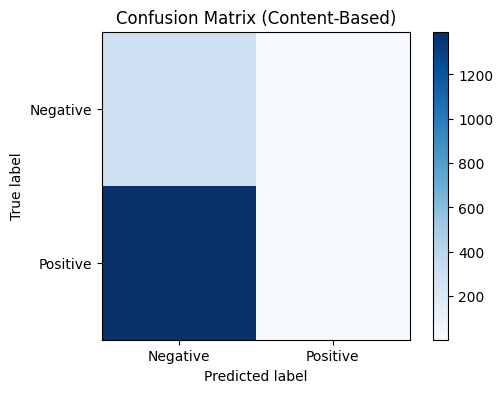


Classification Report (Content-Based):
              precision    recall  f1-score   support

           0       0.18      0.99      0.30       302
           1       0.81      0.01      0.02      1406

    accuracy                           0.18      1708
   macro avg       0.49      0.50      0.16      1708
weighted avg       0.70      0.18      0.07      1708


Precision: 0.8125
Recall: 0.009246088193456615
F1-Score: 0.01828410689170183
Accuracy: 0.18266978922716628


In [128]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import pandas as pd

# **Veriyi Hazırlama**
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserId', 'ProductId', 'Score']], reader)

# Eğitim ve test veri setlerini ayırma (Surprise metoduyla)
trainset, testset = surprise_train_test_split(data, test_size=0.2)

# SVD modelini oluşturma ve eğitim
svd_model = SVD()
svd_model.fit(trainset)

# Test seti ile tahmin yapma
predictions = svd_model.test(testset)

# RMSE hesaplama
rmse_error = accuracy.rmse(predictions)
print(f"\nRMSE (SVD): {rmse_error}")

# **Kullanıcıya Ürün Önerme Fonksiyonu**
def recommend_products_content(user_id, df, model, num_recommendations=5):
    unique_products = df['ProductId'].unique()
    predictions = [model.predict(user_id, product) for product in unique_products]
    predictions.sort(key=lambda x: x.est, reverse=True)
    recommended_products = [pred.iid for pred in predictions[:num_recommendations]]
    return recommended_products

# Örnek bir kullanıcı için öneri alalım
user_id = df['UserId'].sample().values[0]
recommended_products = recommend_products_content(user_id, df, svd_model)
print(f"\nÖnerilen ürünler (SVD): {recommended_products}")

# **Test setini DataFrame'e dönüştürme**
testset_df = pd.DataFrame(testset, columns=['UserId', 'ProductId', 'Score'])

# Gerçek etiketler (testset'teki gerçek etiketler)
testset_df['Sentiment'] = testset_df['Score'].apply(lambda x: 1 if x > 3 else 0)
y_true = testset_df['Sentiment']

# İçerik tabanlı modelin tahmin ettiği ürünleri almak için öneri fonksiyonunu kullanıyoruz
# Bu kısmı düzeltmemiz gerekiyor çünkü `recommend_products_content` sadece tek bir kullanıcı için öneri yapıyor
y_pred_content = []
for product in testset_df['ProductId']:
    if product in recommended_products:
        y_pred_content.append(1)  # Eğer önerilen ürünse 1, değilse 0
    else:
        y_pred_content.append(0)

# Precision, Recall ve F1 Score Hesaplama
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred_content, average='binary')
accuracy_content = accuracy_score(y_true, y_pred_content)

# Grafik Gösterimi: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_content)
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Content-Based)")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.show()

# **Classification Report** Gösterimi
print(f"\nClassification Report (Content-Based):")
print(classification_report(y_true, y_pred_content))

# Ekstra performans metrikleri
print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {fscore}")
print(f"Accuracy: {accuracy_content}")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2044

RMSE (KNN): 1.2043779386756495

Önerilen ürünler (KNN): ['B001E4KFG0', 'B00813GRG4', 'B000UA0QIQ', 'B000E7L2R4', 'B00171APVA']


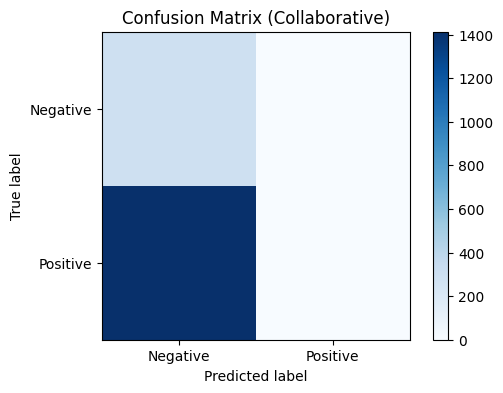


Classification Report (Collaborative):
              precision    recall  f1-score   support

           0       0.17      1.00      0.29       293
           1       1.00      0.00      0.00      1415

    accuracy                           0.17      1708
   macro avg       0.59      0.50      0.15      1708
weighted avg       0.86      0.17      0.05      1708


Precision: 1.0
Recall: 0.0014134275618374558
F1-Score: 0.0028228652081863093
Accuracy: 0.17271662763466042


In [125]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# **Veriyi Hazırlama**
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserId', 'ProductId', 'Score']], reader)

# Eğitim ve test veri setlerini ayırma (Surprise metoduyla)
trainset, testset = surprise_train_test_split(data, test_size=0.2)

# KNNBasic modelini oluşturma ve eğitim
knn_model = KNNBasic()
knn_model.fit(trainset)

# Test seti ile tahmin yapma
predictions = knn_model.test(testset)

# RMSE hesaplama
rmse_error = accuracy.rmse(predictions)
print(f"\nRMSE (KNN): {rmse_error}")

# **Kullanıcıya Ürün Önerme Fonksiyonu**
def recommend_products(user_id, df, model, num_recommendations=5):
    unique_products = df['ProductId'].unique()
    predictions = [model.predict(user_id, product) for product in unique_products]
    predictions.sort(key=lambda x: x.est, reverse=True)
    recommended_products = [pred.iid for pred in predictions[:num_recommendations]]
    return recommended_products

# Örnek bir kullanıcı için öneri alalım
user_id = df['UserId'].sample().values[0]
recommended_products = recommend_products(user_id, df, knn_model)
print(f"\nÖnerilen ürünler (KNN): {recommended_products}")

# **Test setini DataFrame'e dönüştürme**
testset_df = pd.DataFrame(testset, columns=['UserId', 'ProductId', 'Score'])
testset_df['Sentiment'] = testset_df['Score'].apply(lambda x: 1 if x > 3 else 0)

# Gerçek etiketler (testset'teki gerçek etiketler)
y_true = testset_df['Sentiment']

# İşbirlikçi modelin tahmin ettiği ürünleri almak için öneri fonksiyonunu kullanıyoruz
y_pred_collaborative = [1 if product in recommended_products else 0 for product in testset_df['ProductId']]

# Precision, Recall ve F1 Score Hesaplama
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred_collaborative, average='binary')
accuracy_collaborative = accuracy_score(y_true, y_pred_collaborative)

# Grafik Gösterimi: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_collaborative)
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Collaborative)")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.show()

# **Classification Report** Gösterimi
print(f"\nClassification Report (Collaborative):")
print(classification_report(y_true, y_pred_collaborative))

# Ekstra performans metrikleri
print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {fscore}")
print(f"Accuracy: {accuracy_collaborative}")

Computing the msd similarity matrix...
Done computing similarity matrix.

Hibrid Önerilen Ürünler: ['B00008JOL0', 'B002QWP89S', 'B001RVFDOO', 'B001I8BNMC', 'B000EVIDUY']


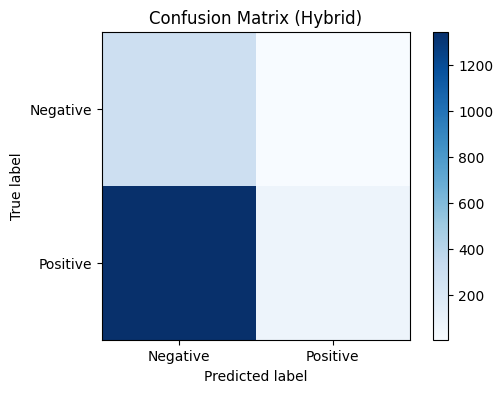


Classification Report (Hybrid):
              precision    recall  f1-score   support

           0       0.18      0.99      0.30       294
           1       0.95      0.05      0.09      1414

    accuracy                           0.21      1708
   macro avg       0.56      0.52      0.20      1708
weighted avg       0.81      0.21      0.13      1708


Precision: 0.9459459459459459
Recall: 0.04950495049504951
F1-Score: 0.09408602150537634
Accuracy: 0.2107728337236534


In [127]:
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# **Veriyi Hazırlama**
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserId', 'ProductId', 'Score']], reader)

# Eğitim ve test veri setlerini ayırma (Surprise metoduyla)
trainset, testset = surprise_train_test_split(data, test_size=0.2)

# **SVD Modelini Oluşturma ve Eğitim**
svd_model = SVD()
svd_model.fit(trainset)

# **KNN Modelini Oluşturma ve Eğitim**
knn_model = KNNBasic()
knn_model.fit(trainset)

# **Hibrid Öneri Sistemi**
def hybrid_recommend(user_id, df, svd_model, knn_model, num_recommendations=5):
    unique_products = df['ProductId'].unique()

    # SVD ile öneriler
    svd_predictions = [svd_model.predict(user_id, product) for product in unique_products]
    svd_predictions.sort(key=lambda x: x.est, reverse=True)
    svd_recommended = [pred.iid for pred in svd_predictions[:num_recommendations]]

    # KNN ile öneriler
    knn_predictions = [knn_model.predict(user_id, product) for product in unique_products]
    knn_predictions.sort(key=lambda x: x.est, reverse=True)
    knn_recommended = [pred.iid for pred in knn_predictions[:num_recommendations]]

    # Hibrid öneri: SVD ve KNN sonuçlarının birleşimi
    hybrid_recommendations = list(set(svd_recommended + knn_recommended))
    return hybrid_recommendations[:num_recommendations]

# Örnek bir kullanıcı için hibrid öneri alalım
user_id = df['UserId'].sample().values[0]
hybrid_recs = hybrid_recommend(user_id, df, svd_model, knn_model)
print(f"\nHibrid Önerilen Ürünler: {hybrid_recs}")

# **Test setini DataFrame'e dönüştürme**
testset_df = pd.DataFrame(testset, columns=['UserId', 'ProductId', 'Score'])
testset_df['Sentiment'] = testset_df['Score'].apply(lambda x: 1 if x > 3 else 0)

# Gerçek etiketler (testset'teki gerçek etiketler)
y_true = testset_df['Sentiment']

# Hibrid modelin tahmin ettiği ürünleri almak için öneri fonksiyonunu kullanıyoruz
y_pred_hybrid = [1 if product in hybrid_recs else 0 for product in testset_df['ProductId']]

# Precision, Recall ve F1 Score Hesaplama
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred_hybrid, average='binary')
accuracy_hybrid = accuracy_score(y_true, y_pred_hybrid)

# Grafik Gösterimi: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_hybrid)
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Hybrid)")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.show()

# **Classification Report** Gösterimi
print(f"\nClassification Report (Hybrid):")
print(classification_report(y_true, y_pred_hybrid))

# Ekstra performans metrikleri
print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {fscore}")
print(f"Accuracy: {accuracy_hybrid}")